# Notebook to perform sentiment analysis and topic modelling for Fukudon. Please read the text below.

# Important Information
This notebook was ran on Google Colab Pro (not drive mounted). To replicate this notebook:

<ol>
    <li> Import notebook to colab</li>
    <li> Import Fukudon's combined reviews dataset. Dataset can be found in repository: <b>/data/combined_reviews.csv</b></li>
    <li> Change runtime to GPU</li>
    <li> Install dependencies (run code block below. You may be asked to restart runtime after installing. IF you do so, please ensure runtime is GPU again.</li>
</ol>

# Expected directory
In google colab, your directory should now consist of one folder and two files:
<ol>
    <li>sample_data folder: Default folder from Google Colab</li>
    <li>combined_reviews.csv: Dataset comprising Fukudon's reviews from all data sources</li>
</ol>

# Install and import dependencies

In [49]:
!pip install bertopic
!pip install datasets transformers[sentencepiece]

In [2]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import string
import re
import string

from PIL import Image
import os
from os import path
import csv

from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Helper Functions

In [4]:
# Function to create a dictionary with word counts from dataframe 
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row["cleaned_reviews"]
        
        # this will split a sentence into words 
        tokens = text.split()
        
        # iterate each word 
        for i in range(0, len(tokens)):
            token = tokens[i].rstrip()
            token=token.strip()
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

In [5]:
# Function to create Word Cloud
def makeImage(termDict):
    
    wc = WordCloud(max_font_size=150, width=1280, height=720, background_color="white")    

    # generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    
    # show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

In [6]:
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\n','',text) #remove \n which act as extra lines in reviews
    return text

In [7]:
# Variable 'stop' set to list of english stopwords from nltk library
stop = stopwords.words('english')
stop.extend(['ngl','lol','thats','theyre','tbh','idk','rall','theres','youre','yall','dont','aint','ive','arent','havent','wtf','thatll','omg','theyd','woah','fucking','wouldve','shit','wouldve','werent','repost','deleted','heres','wouldnt','fuck','cant','haha'])

def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

In [8]:
def read_word_count_file(file_path):
    with open(file_path, mode='r', encoding="latin1") as infile:
        reader = csv.reader(infile)
        counts = {}
        for row in reader:
            if len(row) >0 :
                counts[row[0]] = float(row[1])
        return counts

# Get Data

In [9]:
comments_df = pd.read_csv("combined_reviews.csv", encoding="unicode-escape")
comments_df = comments_df.rename(columns={"reviews": "Reviews"})

In [ ]:
comments_df.head()

# Data Cleaning

In [12]:
comments_df["clean_text_1"]=comments_df['Reviews'].apply(clean_text_round1)
comments_df

,Reviews,clean_text_1
0,Sukiyaki Beef is good. \n\nSpicy garlic pork c...,sukiyaki beef is good spicy garlic pork cutlet...
1,"One of my fav store for pork collar. However, ...",one of my fav store for pork collar however to...
2,"Delicious food, prompt delivery and excellent ...",delicious food prompt delivery and excellent s...
3,Super valued for money. Super affordable but y...,super valued for money super affordable but ye...
4,Definitely a surprise find at punggol. Really ...,definitely a surprise find at punggol really a...
...,...,...
118,The element that sealed the deal for us was th...,the element that sealed the deal for us was th...
119,The soft scrambled eggs with onion was perfect...,the soft scrambled eggs with onion was perfect...
120,Their rice bowls could definitely do with more...,their rice bowls could definitely do with more...
121,Felt that the Asian Fusion Donburi branding ...,felt that the asian fusion donburi branding ...


In [13]:
comments_df['clean_text_2']=comments_df['clean_text_1'].apply(clean_text_round2)
comments_df

,Reviews,clean_text_1,clean_text_2
0,Sukiyaki Beef is good. \n\nSpicy garlic pork c...,sukiyaki beef is good spicy garlic pork cutlet...,sukiyaki beef good spicy garlic pork cutlet go...
1,"One of my fav store for pork collar. However, ...",one of my fav store for pork collar however to...,one fav store pork collar however today pieces...
2,"Delicious food, prompt delivery and excellent ...",delicious food prompt delivery and excellent s...,delicious food prompt delivery excellent servi...
3,Super valued for money. Super affordable but y...,super valued for money super affordable but ye...,super valued money super affordable yet restau...
4,Definitely a surprise find at punggol. Really ...,definitely a surprise find at punggol really a...,definitely surprise find punggol really afford...
...,...,...,...
118,The element that sealed the deal for us was th...,the element that sealed the deal for us was th...,element sealed deal us runny egg simmered dash...
119,The soft scrambled eggs with onion was perfect...,the soft scrambled eggs with onion was perfect...,soft scrambled eggs onion perfectly cooked
120,Their rice bowls could definitely do with more...,their rice bowls could definitely do with more...,rice bowls could definitely sauce
121,Felt that the Asian Fusion Donburi branding ...,felt that the asian fusion donburi branding ...,felt asian fusion donburi branding bit far s...


In [14]:
cleaned_df = pd.DataFrame()
cleaned_df["cleaned_reviews"] = comments_df["clean_text_2"]
cleaned_df.head()

,cleaned_reviews
0,sukiyaki beef good spicy garlic pork cutlet go...
1,one fav store pork collar however today pieces...
2,delicious food prompt delivery excellent servi...
3,super valued money super affordable yet restau...
4,definitely surprise find punggol really afford...


In [15]:
# Get word frequency
result = count_words_from_dataframe(cleaned_df)

# sorting the words based on their frequency
sorted_dic = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

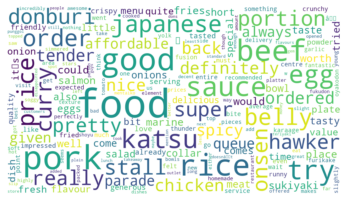

In [16]:
makeImage(sorted_dic)

In [17]:
reviews_list = cleaned_df['cleaned_reviews'].tolist()

In [18]:
reviews_list[:5]

['sukiyaki beef good spicy garlic pork cutlet good prom belly katsu good thunder fries mentai sauce sibei good',
 'one fav store pork collar however today pieces burnt meat ð\x9f\x98\x93',
 'delicious food prompt delivery excellent service ð\x9f\x92¯ð\x9f\x92¯ð\x9f\x92¯',
 'super valued money super affordable yet restaurant standard sukiyaki beef donð\x9f\x98\x8d returning weekly satisfy cravingsð\x9f\x98\x81yes friendly staffs tooð\x9f¤£',
 'definitely surprise find punggol really affordable japanese food kptpeople behind counter really nice friendlyordered pork belly katsu katsu platter extra serving rice onsen egg less ð\x9f\x98\x9cð\x9f\x98\x9cfood point portions bigsurely coming back']

# Sentiment Analysis with HuggingFace

In [19]:
# Load the "sentiment prediction" model.
classifier = pipeline("sentiment-analysis", device = 0)

# input: sentence, output: sentiment label and score
sentiment_list= classifier(reviews_list)
zipped_list=[]
for i in range(len(reviews_list)):
    zipped=[reviews_list[i],sentiment_list[i]['label'],sentiment_list[i]['score']]
    zipped_list.append(zipped)

df_sentiment=pd.DataFrame(zipped_list, columns=['review','sentiment','sentiment score'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [20]:
df_sentiment.head()

,review,sentiment,sentiment score
0,sukiyaki beef good spicy garlic pork cutlet go...,POSITIVE,0.996993
1,one fav store pork collar however today pieces...,NEGATIVE,0.998685
2,delicious food prompt delivery excellent servi...,POSITIVE,0.999809
3,super valued money super affordable yet restau...,NEGATIVE,0.808793
4,definitely surprise find punggol really afford...,POSITIVE,0.936463


In [21]:
positive_review = df_sentiment[df_sentiment['sentiment'] == 'POSITIVE']
positive_review.head()

,review,sentiment,sentiment score
0,sukiyaki beef good spicy garlic pork cutlet go...,POSITIVE,0.996993
2,delicious food prompt delivery excellent servi...,POSITIVE,0.999809
4,definitely surprise find punggol really afford...,POSITIVE,0.936463
6,groupbuy communication good arrived hot hot po...,POSITIVE,0.999091
7,awesome pplawesome food ð,POSITIVE,0.999334


In [22]:
positive_review['sentiment score'].mean()

0.9775241722420949

In [23]:
negative_review = df_sentiment[df_sentiment['sentiment'] == 'NEGATIVE']
negative_review.head()

,review,sentiment,sentiment score
1,one fav store pork collar however today pieces...,NEGATIVE,0.998685
3,super valued money super affordable yet restau...,NEGATIVE,0.808793
5,place certainly worthy tried pork katsu beef f...,NEGATIVE,0.996581
14,picture doesnât food justice fav place pork ...,NEGATIVE,0.992504
15,marine parade saw stall selling japanese const...,NEGATIVE,0.997620


In [24]:
negative_review['sentiment score'].mean()

0.9605516515127043

In [25]:
df_sentiment['sentiment'].value_counts()

POSITIVE    82
NEGATIVE    41
Name: sentiment, dtype: int64

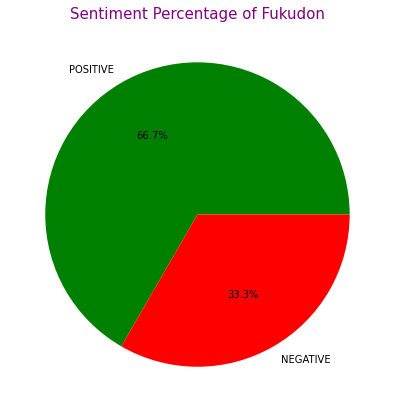

<Figure size 432x288 with 0 Axes>

In [26]:
df = df_sentiment['sentiment'].value_counts()
#pie chart
df.dropna(inplace = True)
labels =df.index
colors = ['green','red']
explode = [0,0]
sizes = df.values

# visual
plt.figure(figsize = (7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Sentiment Percentage of Fukudon",color = 'purple',fontsize = 15)
fig1 = plt.gcf()
plt.show()
plt.draw()

In [27]:
positive_review_list=positive_review['review'].tolist()
negative_review_list=negative_review['review'].tolist()

# Topic Modelling

## For Positive Reviews

In [28]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(positive_review_list)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-04-11 09:30:27,643 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-11 09:30:35,608 - BERTopic - Reduced dimensionality with UMAP
2022-04-11 09:30:35,624 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [29]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,42,-1_food_pork_good_katsu
1,0,24,0_sauce_curry_good_try
2,1,16,1_food_affordable_nice_good


In [30]:
topic_model.get_topic(0)  # Select the most frequent topic

[('sauce', 0.08833780880143054),
 ('curry', 0.06646853443332545),
 ('good', 0.060613477463246294),
 ('try', 0.056623347331767604),
 ('pork', 0.048647695519619984),
 ('karaage', 0.04791616600611067),
 ('must', 0.04791616600611067),
 ('tender', 0.044259682344475915),
 ('love', 0.044259682344475915),
 ('rice', 0.044259682344475915)]

In [31]:
topic_model.visualize_barchart()

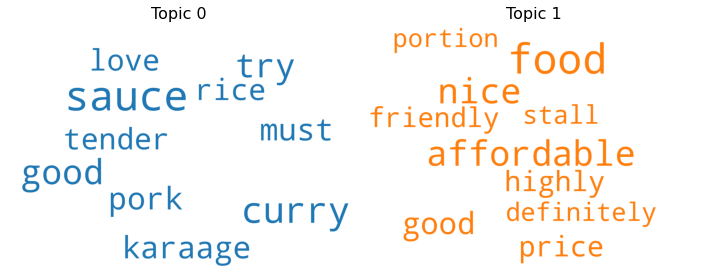

<Figure size 432x288 with 0 Axes>

In [32]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

tps = topic_model.get_topics()

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(tps[i])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
fig2 = plt.gcf()
plt.show()
plt.draw()

In [33]:
#value of n_clusters doens't seem to affect the heatmap
topic_model.visualize_heatmap(n_clusters=2, width=1000, height=1000)

In [34]:
# Visualize Topic Probabilities
topic_model.visualize_distribution(probs[1], min_probability=0.015)

In [35]:
topic_model.get_topics()

{-1: [('food', 0.07284199871209202),
  ('pork', 0.05862571447296582),
  ('good', 0.05113203964776643),
  ('katsu', 0.04772245764314861),
  ('ordered', 0.0433405938698318),
  ('beef', 0.0433405938698318),
  ('fries', 0.04205341633840284),
  ('try', 0.041795305956479296),
  ('belly', 0.04090496369412738),
  ('delicious', 0.03733638007830091)],
 0: [('sauce', 0.08833780880143054),
  ('curry', 0.06646853443332545),
  ('good', 0.060613477463246294),
  ('try', 0.056623347331767604),
  ('pork', 0.048647695519619984),
  ('karaage', 0.04791616600611067),
  ('must', 0.04791616600611067),
  ('tender', 0.044259682344475915),
  ('love', 0.044259682344475915),
  ('rice', 0.044259682344475915)],
 1: [('food', 0.21474239569641657),
  ('affordable', 0.14841868583612436),
  ('nice', 0.14841868583612436),
  ('good', 0.11131583226020503),
  ('price', 0.09643922881960329),
  ('highly', 0.09246771543366397),
  ('friendly', 0.08799739135446541),
  ('stall', 0.0786280368516881),
  ('portion', 0.07629285328960

## Negative Reviews

In [36]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(negative_review_list)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-04-11 09:30:51,026 - BERTopic - Transformed documents to Embeddings
2022-04-11 09:30:54,023 - BERTopic - Reduced dimensionality with UMAP
2022-04-11 09:30:54,034 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [37]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,41,-1_rice_beef_pork_food


In [38]:
topic_model.get_topic(-1)  # Select the most frequent topic

[('rice', 0.06729286502096068),
 ('beef', 0.06277262013599363),
 ('pork', 0.06277262013599363),
 ('food', 0.060464163542451245),
 ('egg', 0.04581727673748202),
 ('order', 0.04581727673748202),
 ('onsen', 0.04056917573600637),
 ('katsu', 0.04056917573600637),
 ('given', 0.037860317063629904),
 ('donburi', 0.037860317063629904)]

### Insufficient data resulted in poor topic modelling results. We will proceed with wordclouds to derive insight instead

In [42]:
negative_review["cleaned_reviews"] = negative_review["review"]

In [44]:
negative_review = negative_review[["cleaned_reviews"]]

In [45]:
negative_review.head()

,cleaned_reviews
1,one fav store pork collar however today pieces...
3,super valued money super affordable yet restau...
5,place certainly worthy tried pork katsu beef f...
14,picture doesnât food justice fav place pork ...
15,marine parade saw stall selling japanese const...


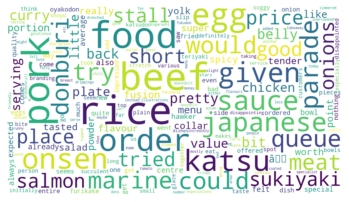

In [48]:
result = count_words_from_dataframe(negative_review)
makeImage(result)